<a href="https://colab.research.google.com/github/treasure-data/td-notebooks/blob/master/machine-learning/foodmart/machine-learning-with-treasure-data-for-python-users.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning with Python and Treasure Data

This article introduces how to collaborate with Arm Treasure Data and Python for machine learning. In this tutorial, we will use classical foodmart dataset to **predict purchase number**.

Through this article, you will learn how to:

- fetch a dataset on Arm Treasure Data with Python
- write back a prediction result to Arm Treasure Data with Python


# Prerequisites

This tutorial assumes you are familiar with:

- basic knowledge of Machine learning and Python
- Treasure Data


# Fetch data from Treasure Data

## Prepare Python packages

To connect to Treasure Data with Python, you have to install the following Python package. Running the following code, you can install Python packages for this article.

In [0]:
!pip install --quiet pytd

# For outside of Google Colaboratory, you should install the following packages
#!pip install --quiet matplotlib scikit-learn pandas seaborn lightgbm

Now you can load packages for data science and the library for Treasure Data connection.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the Python library for Treasure Data
import pytd.pandas_td as td

## Set API key for Treasure Data

Before connecting to TD, you have to set TD API master key. Your TD API key can be found in [the TD console profile page](https://console.treasuredata.com/app/users/current).

Setting the api key into `TD_API_KEY`, TD libraries can connect to TD seamlessly.

In [0]:
import os
from getpass import getpass

td_api_key = getpass('Enter TD API KEY (master key) here ->')

os.environ['TD_API_KEY'] = td_api_key
print("Succeeded to set the API key")

Enter TD API KEY (master key) here ->··········
Succeeded to set the API key


You can set endpoint in the following code:

In [0]:
os.environ['TD_API_SERVER'] = endpoint = 'https://api.treasuredata.com'

## Connect to Treasure Data

Let's connect and fetch data from TD. After creating an engine with `create_engine` function, you can get TD data with SQL using `read_td` function. If you want to load a small table to pandas, you can use `read_td_table` function instead.

Let's make a connection with *pytd*.

In [0]:
con = td.connect(apikey=td_api_key, endpoint=endpoint)

### Upload sales and customer data to Treasure Data

Let's download the CSV files from GitHub and then upload them to Treasure Data.

First, create your own database if not exists. Change `db_name` if you want to use another database to ingest.


In [0]:
import tdclient

# Replace db_name to your database name
db_name = 'foodmart'

# Create a database if not exists
tdc = con.api_client
try:
    tdc.create_database(db_name)
except tdclient.errors.AlreadyExistsError as e:
    print(f"Database {db_name} exists.")
    pass

After downloading CSV files from GitHub, you can upload them to Treasure Data.

In [0]:
customer_orig = pd.read_csv("https://github.com/neo4j-examples/neo4j-foodmart-dataset/raw/master/data/customer.csv")
sales_orig = pd.read_csv("https://github.com/neo4j-examples/neo4j-foodmart-dataset/raw/master/data/sales.csv")

customer_orig.head()

,customer_id,account_num,lname,fname,mi,address1,address2,address3,address4,city,state_province,postal_code,country,customer_region_id,phone1,phone2,birthdate,marital_status,yearly_income,gender,total_children,num_children_at_home,education,date_accnt_opened,member_card,occupation,houseowner,num_cars_owned,fullname
0,1,87462024688,Nowmer,Sheri,A.,2433 Bailey Road,NaN,NaN,NaN,Tlaxiaco,Oaxaca,15057,Mexico,30,271-555-9715,119-555-1969,1961-08-26,M,$30K - $50K,F,4,2,Partial High School,1991-09-10,Bronze,Skilled Manual,Y,4,Sheri Nowmer
1,2,87470586299,Whelply,Derrick,I.,2219 Dewing Avenue,NaN,NaN,NaN,Sooke,BC,17172,Canada,101,211-555-7669,807-555-9033,1915-07-03,S,$70K - $90K,M,1,0,Partial High School,1993-03-11,Bronze,Professional,N,3,Derrick Whelply
2,3,87475757600,Derry,Jeanne,NaN,7640 First Ave.,NaN,NaN,NaN,Issaquah,WA,73980,USA,21,656-555-2272,221-555-2493,1910-06-21,M,$50K - $70K,F,1,1,Bachelors Degree,1991-06-11,Bronze,Professional,Y,2,Jeanne Derry
3,4,87500482201,Spence,Michael,J.,337 Tosca Way,NaN,NaN,NaN,Burnaby,BC,74674,Canada,92,929-555-7279,272-555-2844,1969-06-20,M,$10K - $30K,M,4,4,Partial High School,1994-05-21,Normal,Skilled Manual,N,2,Michael Spence
4,5,87514054179,Gutierrez,Maya,NaN,8668 Via Neruda,NaN,NaN,NaN,Novato,CA,57355,USA,42,387-555-7172,260-555-6936,1951-05-10,S,$30K - $50K,F,3,0,Partial College,1992-08-21,Silver,Manual,N,3,Maya Gutierrez


In [0]:
sales_orig.head()

,product_id,time_id,customer_id,promotion_id,store_id,store_sales,store_cost,unit_sales
0,337,371,6280,NaN,2,1.50,0.5100,2
1,1512,371,6280,NaN,2,1.62,0.6318,3
2,963,371,4018,NaN,2,2.40,0.7200,1
3,181,371,4018,NaN,2,2.79,1.0323,3
4,1383,371,4018,NaN,2,5.18,2.1756,2


You can upload pandas DataFrames by using `td.to_td()` function.

In [0]:
td.to_td(customer_orig, f'{db_name}.customer', con, if_exists='overwrite', index=False)
td.to_td(sales_orig, f'{db_name}.sales', con, if_exists='overwrite', index=False)

uploading data converted into a CSV file
performing a bulk import job
imported 10281 records.
uploading data converted into a CSV file
performing a bulk import job
imported 269720 records.


Let's read tables from TreasureData by using `td_read_td_table()` function.

In [0]:
engine = td.create_engine('presto:{}'.format(db_name), con=con)

# `read_td_table` limits row number as 10000 by default.
sales = td.read_td_table("sales", engine, limit=270000)
customer = td.read_td_table("customer", engine, limit=11000)

## Check the overview of data

We get sales and customer data as pandas DataFrame, let's see the snippet, stats, and column names for customer data.

Here is an example of sales data.

In [0]:
sales.head()

,product_id,time_id,customer_id,promotion_id,store_id,store_sales,store_cost,unit_sales,time
0,920,1087,7002,None,24,2.19,0.8541,3,1564053311
1,831,1087,7002,None,24,6.32,2.2752,4,1564053311
2,1226,1087,2584,None,24,11.84,4.9728,4,1564053311
3,644,1087,2584,None,24,1.74,0.6786,2,1564053311
4,1247,1087,2584,None,24,3.36,1.2432,2,1564053311


Here is the example of customer data. Note that, column number is too many to show up with.

In [0]:
customer.head()

,customer_id,account_num,lname,fname,mi,address1,address2,address3,address4,city,state_province,postal_code,country,customer_region_id,phone1,phone2,birthdate,marital_status,yearly_income,gender,total_children,num_children_at_home,education,date_accnt_opened,member_card,occupation,houseowner,num_cars_owned,fullname,time
0,10180,86266993284,Weindel,Ernie,NaN,2725 Deerwood Court,NaN,None,None,Imperial Beach,CA,81279,USA,14,518-555-6046,521-555-6953,1973-04-07,M,$30K - $50K,M,3,3,Partial College,1993-03-10,Golden,Management,N,3,Ernie Weindel,1564053244
1,10181,86285618543,Smith,Richard,J.,9093 Kirker Pass Road,NaN,None,None,Royal Oak,BC,13202,Canada,100,637-555-2281,748-555-5703,1952-07-14,M,$50K - $70K,F,1,1,Bachelors Degree,1991-03-09,Bronze,Management,N,4,Richard Smith,1564053244
2,10182,86327680945,Billingsley,Wendy,H.,3753 Shenandoah Drive,NaN,None,None,La Mesa,CA,32236,USA,11,384-555-2834,934-555-6941,1918-03-05,M,$50K - $70K,F,0,0,Partial High School,1992-10-20,Bronze,Manual,Y,3,Wendy Billingsley,1564053244
3,10183,86336365900,Kryway,Elizabeth,NaN,375 Hillview Drive,NaN,None,None,Colma,CA,30282,USA,32,764-555-1356,284-555-4320,1969-11-10,M,$30K - $50K,M,5,5,High School Degree,1990-11-17,Golden,Manual,Y,3,Elizabeth Kryway,1564053244
4,10184,86350565552,Saraj,Sange,U.,5288 Carletto Drive,NaN,None,None,Santa Anita,DF,87223,Mexico,108,422-555-7277,380-555-1927,1948-08-19,M,$10K - $30K,F,5,5,Partial High School,1991-12-27,Normal,Skilled Manual,N,0,Sange Saraj,1564053244


In [0]:
# Show customer table column names.
print("Columns of customer")
list(customer)

Columns of customer


['customer_id',
 'account_num',
 'lname',
 'fname',
 'mi',
 'address1',
 'address2',
 'address3',
 'address4',
 'city',
 'state_province',
 'postal_code',
 'country',
 'customer_region_id',
 'phone1',
 'phone2',
 'birthdate',
 'marital_status',
 'yearly_income',
 'gender',
 'total_children',
 'num_children_at_home',
 'education',
 'date_accnt_opened',
 'member_card',
 'occupation',
 'houseowner',
 'num_cars_owned',
 'fullname',
 'time']

Let's check the stats for sales and customer data.

In [0]:
# Show sales table stats
sales.describe()

,product_id,time_id,customer_id,store_id,store_sales,store_cost,unit_sales,time
count,269720.000000,269720.000000,269720.000000,269720.000000,269720.000000,269720.000000,269720.000000,2.697200e+05
mean,783.862873,800.004990,5119.390405,12.753730,6.542142,2.618622,3.090201,1.564053e+09
std,447.926131,201.955563,2901.883077,6.349746,3.461318,1.452805,0.835554,0.000000e+00
min,1.000000,367.000000,3.000000,1.000000,0.500000,0.153000,1.000000,1.564053e+09
25%,396.000000,657.000000,2570.000000,7.000000,3.810000,1.498000,3.000000,1.564053e+09
50%,787.000000,830.000000,5090.000000,13.000000,5.940000,2.386500,3.000000,1.564053e+09
75%,1174.000000,968.000000,7614.000000,17.000000,8.670000,3.486000,4.000000,1.564053e+09
max,1559.000000,1095.000000,10281.000000,24.000000,23.640000,10.290000,6.000000,1.564053e+09


In [0]:
# Show customer table stats
customer.describe()

,customer_id,account_num,postal_code,customer_region_id,total_children,num_children_at_home,num_cars_owned,time
count,10281.000000,1.028100e+04,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,1.028100e+04
mean,5141.000000,5.032243e+10,55312.897092,55.071297,2.502675,0.814609,2.223422,1.564053e+09
std,2968.013393,2.534394e+10,26134.855686,31.361667,1.500395,1.294580,1.109816,0.000000e+00
min,1.000000,1.001355e+10,1374.000000,1.000000,0.000000,0.000000,0.000000,1.564053e+09
25%,2571.000000,2.836150e+10,32760.000000,28.000000,1.000000,0.000000,1.000000,1.564053e+09
50%,5141.000000,4.848514e+10,55288.000000,55.000000,3.000000,0.000000,2.000000,1.564053e+09
75%,7711.000000,7.087943e+10,78209.000000,82.000000,4.000000,1.000000,3.000000,1.564053e+09
max,10281.000000,9.996103e+10,99993.000000,109.000000,5.000000,5.000000,4.000000,1.564053e+09


# Build a purchase number prediction model

## Get aggregated data for feature with SQL
Executing SQLs is good for joining and aggregating multiple tables. Let's make a feature table with SQL. `purchase_cnt` is the target column for prediction.

In [0]:
df = td.read_td("""
select
  s1.customer_id, c1.country, c1.total_children, c1.num_children_at_home,
  c1.education, c1.yearly_income, c1.gender, c1.member_card, c1.num_cars_owned,
  count(s1.product_id) as purchase_cnt
from
  sales s1
join
  customer c1
  on s1.customer_id = c1.customer_id
group by
  s1.customer_id, c1.country, c1.total_children, c1.num_children_at_home,
  c1.education, c1.yearly_income, c1.gender, c1.member_card, c1.num_cars_owned""", engine)
df.head()

,customer_id,country,total_children,num_children_at_home,education,yearly_income,gender,member_card,num_cars_owned,purchase_cnt
0,2077,USA,4,2,Graduate Degree,$70K - $90K,M,Bronze,2,116
1,1542,Mexico,3,0,Bachelors Degree,$50K - $70K,F,Bronze,3,41
2,211,Mexico,3,3,Partial High School,$10K - $30K,M,Normal,2,60
3,2079,Mexico,1,0,Partial High School,$50K - $70K,F,Silver,2,14
4,6779,Mexico,0,0,Bachelors Degree,$70K - $90K,M,Bronze,2,24


Additionally, we will create `children_at_home_ratio` column since that might be related to sales.


In [0]:
# Add aggregated feature
df['children_at_home_ratio'] = (df.num_children_at_home / df.total_children).fillna(0.0)

## Check the stats and correlations

You can check the stats of the aggreagted table and correlations of each feature.

In [0]:
# Show stats of the aggregated data
df.describe()

,customer_id,total_children,num_children_at_home,num_cars_owned,purchase_cnt,children_at_home_ratio
count,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000
mean,5144.051572,2.505316,0.805587,2.221556,30.504411,0.287086
std,2953.735594,1.500452,1.294748,1.109897,35.648668,0.411541
min,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2599.250000,1.000000,0.000000,1.000000,10.000000,0.000000
50%,5142.500000,3.000000,0.000000,2.000000,18.000000,0.000000
75%,7699.750000,4.000000,1.000000,3.000000,35.000000,0.666667
max,10281.000000,5.000000,5.000000,4.000000,301.000000,1.000000


Plot the correlation of numerical values to find better feature to predict purchase number.

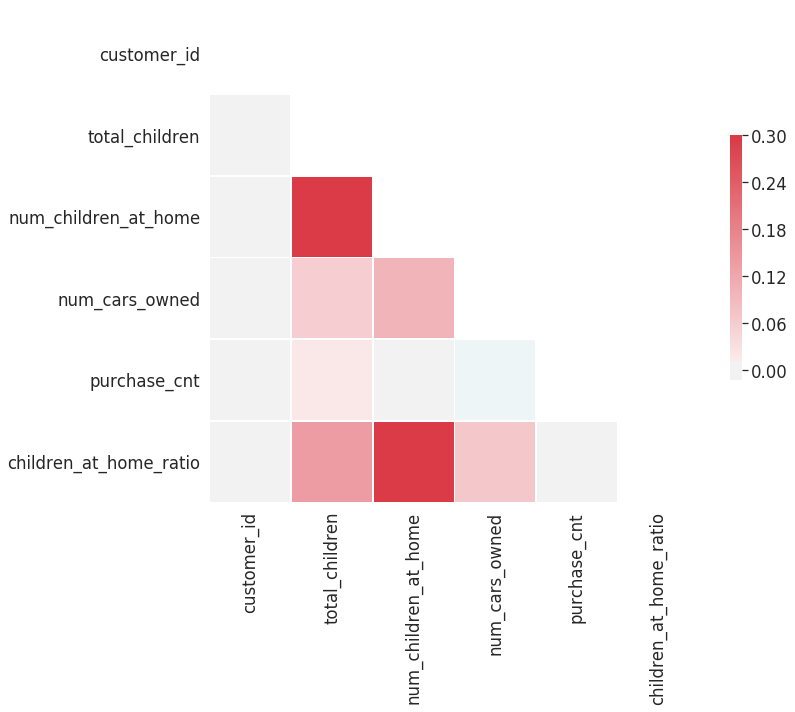

In [0]:
sns.set(style="white", font_scale=1.5)

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can find there is no feature that is strongly correlated with `purchase_cnt`.

## Build a predictive model with LightGBM

[LightGBM](https://github.com/Microsoft/LightGBM) is an open source for machine learning which enables you to classify or regress with gradient boosting algorithm. It is one of the most popular frameworks in Kaggle for solving the problem with structured data.

In [0]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert `object` columns into `int`
categorical_columns = list(df.select_dtypes('object').columns.values)

for column in categorical_columns:
  target_column = df[column]
  le = LabelEncoder()
  label_encoded_column = le.fit_transform(target_column)
  df[column] = pd.Series(label_encoded_column).astype('category')

df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
y_train = df_train.purchase_cnt
y_test = df_test.purchase_cnt
X_train = df_train.drop(columns=['customer_id', 'purchase_cnt'])
X_test = df_test.drop(columns=['customer_id', 'purchase_cnt'])

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [0]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_depth': 6
}

print('Starting training...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Starting training...
[1]	valid_0's l2: 1089.87
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l2: 1058.51
[3]	valid_0's l2: 1031.9
[4]	valid_0's l2: 1010.34
[5]	valid_0's l2: 994.125
[6]	valid_0's l2: 978.605
[7]	valid_0's l2: 965.93
[8]	valid_0's l2: 955.459
[9]	valid_0's l2: 947.62
[10]	valid_0's l2: 941.232
[11]	valid_0's l2: 936.067
[12]	valid_0's l2: 933.133
[13]	valid_0's l2: 930.472
[14]	valid_0's l2: 928.648
[15]	valid_0's l2: 927.002
[16]	valid_0's l2: 925.402
[17]	valid_0's l2: 925.599
[18]	valid_0's l2: 925.84
[19]	valid_0's l2: 925.931
[20]	valid_0's l2: 925.981
Did not meet early stopping. Best iteration is:
[16]	valid_0's l2: 925.402
Starting predicting...
The rmse of prediction is: 30.420414180454888


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


We got [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) as a prediction evaluation for regression.

It is helpful to know feature importance of each column.

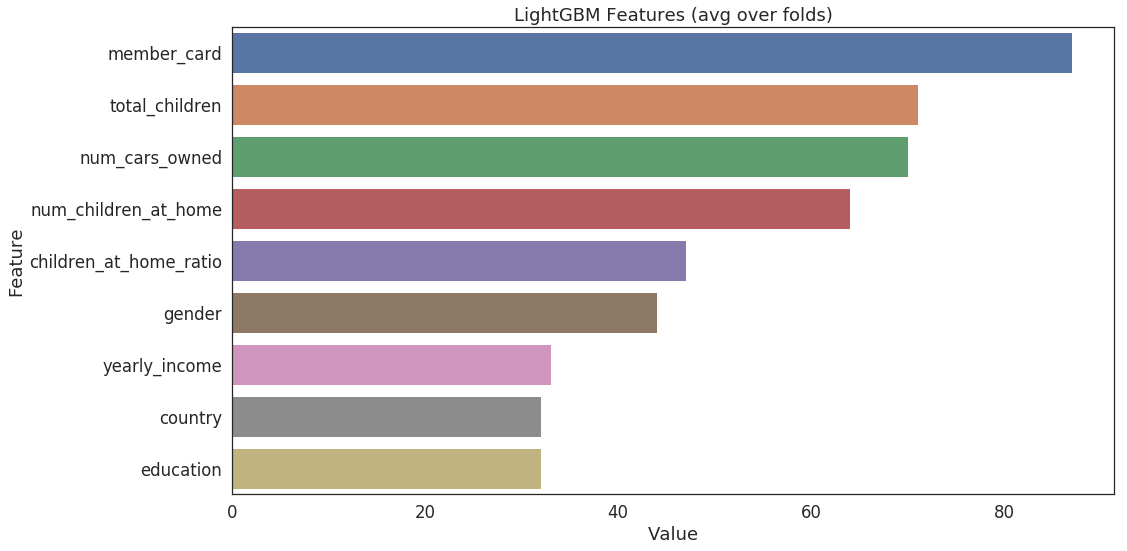

In [0]:
# Plot feature importance
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(16, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)', fontsize=18)
plt.tight_layout()
plt.show()

# Upload prediction result to Treasure Data

You can upload pandas DataFrame with using `to_td` function with running the following code.

If your account doesn't have `plazma_api` role, you have to contact sales@treasure-data.com first, otherwise you'll fail with a 403 error.

In [0]:
X_pred = df_test['customer_id'].to_frame()
X_pred['pred'] = y_pred
X_pred.reset_index(drop=True, inplace=True)

# Upload prediction result to Treasure Data
td.to_td(X_pred, '{}.sales_pred'.format(db_name), con, if_exists='overwrite', index=False)
print("Uploaded")

uploading data converted into a CSV file
performing a bulk import job
imported 2211 records.


Uploaded


Check the data has been ingested properly using `read_td` function.

In [0]:
# Check uploaded data
td.read_td('select * from sales_pred limit 10', engine)

,customer_id,pred,time
0,4030,26.283054,1564053442
1,2159,28.700683,1564053442
2,2063,56.496488,1564053442
3,9111,29.047016,1564053442
4,7823,27.297076,1564053442
5,6454,30.124614,1564053442
6,1726,60.821080,1564053442
7,6119,28.418199,1564053442
8,5340,27.518169,1564053442
9,7536,31.655948,1564053442


# Conclusion

In this example, you learned about:
- How to collaborate with Python and Treasure Data
- How to run a Machine Learning code toward data on Treasure Data
- How to upload your prediction results to Treasure Data


# Bonus: Hyper parameter optimization with optuna

As you can  see in the previous code, LightGBM has certain amount of hyper parameters to be tuned. It could be helpful to use [optuna](https://optuna.org/), hyper parameter optimization library, to find better model parameters.

Using the following code, you can get tuned hyper parameters.

In [0]:
!pip install --quiet optuna

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 81kB 24.4MB/s 
     |████████████████████████████████| 1.0MB 50.9MB/s 
     |████████████████████████████████| 112kB 47.9MB/s 
     |████████████████████████████████| 51kB 20.5MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 471kB 54.0MB/s 


Optuna provides Define-by-Run style API, which offers flexibility and high modularity. Define the `objective` function with LightGBM and optimize the hyper parameters.

In [0]:
# Train with hyper parameter search using optuna

import optuna

def objective(trial):

    params = {"objective": "regression",
              "boosting_type": "gbdt",
              "metric": "l2",
              "learning_rate": trial.suggest_uniform('learning_rate', 1e-5, 1.0),
              "num_leaves": trial.suggest_int('num_leaves', 10, 500),
              "feature_fraction": trial.suggest_uniform('feature_fraction', 0.0, 1.0),
              "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.0, 1.0),
              "bagging_freq": trial.suggest_int('bagging_freq', 5, 100),
              "max_depth": trial.suggest_int('max_depth', 5, 20),
              "verbose": 0,
             }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "l2")
    gbm = lgb.train(params, lgb_train, num_boost_round=500,
                    valid_sets=lgb_eval, callbacks=[pruning_callback])
    
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    error_test = mean_squared_error(y_test, y_pred) ** 0.5
    
    return error_test


study = optuna.create_study()
study.optimize(objective, n_trials=100)

[1]	valid_0's l2: 1020.3
[2]	valid_0's l2: 1035.77
[3]	valid_0's l2: 1024.48
[4]	valid_0's l2: 1034.8
[5]	valid_0's l2: 1056.1
[6]	valid_0's l2: 1063.64
[7]	valid_0's l2: 1069.07
[8]	valid_0's l2: 1077.65
[9]	valid_0's l2: 1080.51
[10]	valid_0's l2: 1089.51
[11]	valid_0's l2: 1094.23
[12]	valid_0's l2: 1098.99
[13]	valid_0's l2: 1105.47
[14]	valid_0's l2: 1110.5
[15]	valid_0's l2: 1108.52
[16]	valid_0's l2: 1104.58
[17]	valid_0's l2: 1113
[18]	valid_0's l2: 1113.47
[19]	valid_0's l2: 1118.16
[20]	valid_0's l2: 1121.63
[21]	valid_0's l2: 1123.65
[22]	valid_0's l2: 1123.43
[23]	valid_0's l2: 1126.94
[24]	valid_0's l2: 1133.03
[25]	valid_0's l2: 1138.29
[26]	valid_0's l2: 1149.34
[27]	valid_0's l2: 1152.15
[28]	valid_0's l2: 1151.44
[29]	valid_0's l2: 1157.3
[30]	valid_0's l2: 1161
[31]	valid_0's l2: 1166.21
[32]	valid_0's l2: 1163.36
[33]	valid_0's l2: 1167.36
[34]	valid_0's l2: 1168.63
[35]	valid_0's l2: 1172.7
[36]	valid_0's l2: 1178.51
[37]	valid_0's l2: 1182.36
[38]	valid_0's l2: 118

[I 2019-07-04 05:23:38,130] Finished trial#0 resulted in value: 39.8173203105236. Current best value is 39.8173203105236 with parameters: {'learning_rate': 0.649852092338076, 'num_leaves': 468, 'feature_fraction': 0.561613881130532, 'bagging_fraction': 0.442051268773093, 'bagging_freq': 88, 'max_depth': 8}.


[1]	valid_0's l2: 1199.22
[2]	valid_0's l2: 1202.86
[3]	valid_0's l2: 1196.63
[4]	valid_0's l2: 1195.29
[5]	valid_0's l2: 1197.16
[6]	valid_0's l2: 1199
[7]	valid_0's l2: 1198.59
[8]	valid_0's l2: 1200.07
[9]	valid_0's l2: 1200
[10]	valid_0's l2: 1025.7
[11]	valid_0's l2: 1025.97
[12]	valid_0's l2: 1026.81
[13]	valid_0's l2: 1025.21
[14]	valid_0's l2: 1025.15
[15]	valid_0's l2: 1027.48
[16]	valid_0's l2: 1026.06
[17]	valid_0's l2: 1001.96
[18]	valid_0's l2: 1005.04
[19]	valid_0's l2: 1005.53
[20]	valid_0's l2: 1005.88
[21]	valid_0's l2: 1005.92
[22]	valid_0's l2: 1004.85
[23]	valid_0's l2: 1001.76
[24]	valid_0's l2: 1002.1
[25]	valid_0's l2: 1001.53
[26]	valid_0's l2: 1002.36
[27]	valid_0's l2: 1002.27
[28]	valid_0's l2: 1002.19
[29]	valid_0's l2: 1003.24
[30]	valid_0's l2: 1003.25
[31]	valid_0's l2: 1003.26
[32]	valid_0's l2: 1003.26
[33]	valid_0's l2: 1002.82
[34]	valid_0's l2: 1005.65
[35]	valid_0's l2: 1005.52
[36]	valid_0's l2: 1005.5
[37]	valid_0's l2: 1005.21
[38]	valid_0's l2: 

[I 2019-07-04 05:23:42,452] Finished trial#1 resulted in value: 32.525323038691596. Current best value is 32.525323038691596 with parameters: {'learning_rate': 0.6152605615720639, 'num_leaves': 412, 'feature_fraction': 0.04631300033300789, 'bagging_fraction': 0.15183414217690216, 'bagging_freq': 39, 'max_depth': 17}.


[1]	valid_0's l2: 1196.45
[2]	valid_0's l2: 1198.85
[3]	valid_0's l2: 1195.96
[4]	valid_0's l2: 1194.83
[5]	valid_0's l2: 1194.36
[6]	valid_0's l2: 1193.66
[7]	valid_0's l2: 1193.17
[8]	valid_0's l2: 1193.02
[9]	valid_0's l2: 1192.79
[10]	valid_0's l2: 1041.36
[11]	valid_0's l2: 1041.42
[12]	valid_0's l2: 1041.82
[13]	valid_0's l2: 1043.02
[14]	valid_0's l2: 1043.05
[15]	valid_0's l2: 1042.39
[16]	valid_0's l2: 1042.32
[17]	valid_0's l2: 1005.51
[18]	valid_0's l2: 1005.65
[19]	valid_0's l2: 1005.35
[20]	valid_0's l2: 1005.21
[21]	valid_0's l2: 1005.14
[22]	valid_0's l2: 1005.87
[23]	valid_0's l2: 997.486
[24]	valid_0's l2: 997.446
[25]	valid_0's l2: 997.329
[26]	valid_0's l2: 997.686
[27]	valid_0's l2: 997.655
[28]	valid_0's l2: 998.155
[29]	valid_0's l2: 998.19
[30]	valid_0's l2: 998.467
[31]	valid_0's l2: 998.613
[32]	valid_0's l2: 998.817
[33]	valid_0's l2: 998.806
[34]	valid_0's l2: 997.814
[35]	valid_0's l2: 997.409
[36]	valid_0's l2: 997.374
[37]	valid_0's l2: 997.45
[38]	valid_0

[I 2019-07-04 05:23:46,879] Finished trial#2 resulted in value: 31.66474386844767. Current best value is 31.66474386844767 with parameters: {'learning_rate': 0.4909255946289933, 'num_leaves': 432, 'feature_fraction': 0.1352911954482725, 'bagging_fraction': 0.8121371713948112, 'bagging_freq': 31, 'max_depth': 20}.


[1]	valid_0's l2: 1028.08
[2]	valid_0's l2: 1049.86
[3]	valid_0's l2: 1054.45
[4]	valid_0's l2: 1070.49
[5]	valid_0's l2: 1089.66
[6]	valid_0's l2: 1094.11
[7]	valid_0's l2: 1119.51
[8]	valid_0's l2: 1150.22
[9]	valid_0's l2: 1147.02
[10]	valid_0's l2: 1170.73
[11]	valid_0's l2: 1183.3
[12]	valid_0's l2: 1215.18
[13]	valid_0's l2: 1228.37
[14]	valid_0's l2: 1231.91
[15]	valid_0's l2: 1243.21
[16]	valid_0's l2: 1245.49
[17]	valid_0's l2: 1262.98
[18]	valid_0's l2: 1283.38
[19]	valid_0's l2: 1297.01
[20]	valid_0's l2: 1310.43
[21]	valid_0's l2: 1319.7
[22]	valid_0's l2: 1328.49
[23]	valid_0's l2: 1345.44
[24]	valid_0's l2: 1350.36
[25]	valid_0's l2: 1350.38
[26]	valid_0's l2: 1361.13
[27]	valid_0's l2: 1378.3
[28]	valid_0's l2: 1398.68
[29]	valid_0's l2: 1411.39
[30]	valid_0's l2: 1402.24
[31]	valid_0's l2: 1394.95
[32]	valid_0's l2: 1404.51
[33]	valid_0's l2: 1424.66
[34]	valid_0's l2: 1426.83
[35]	valid_0's l2: 1427.51
[36]	valid_0's l2: 1401.62
[37]	valid_0's l2: 1413.95
[38]	valid_0'

[I 2019-07-04 05:23:52,719] Finished trial#3 resulted in value: 48.52294443170425. Current best value is 31.66474386844767 with parameters: {'learning_rate': 0.4909255946289933, 'num_leaves': 432, 'feature_fraction': 0.1352911954482725, 'bagging_fraction': 0.8121371713948112, 'bagging_freq': 31, 'max_depth': 20}.


[1]	valid_0's l2: 1204.08
[2]	valid_0's l2: 1211.24
[3]	valid_0's l2: 1016.25
[4]	valid_0's l2: 1017
[5]	valid_0's l2: 1005.72
[6]	valid_0's l2: 1011.03
[7]	valid_0's l2: 1015.26
[8]	valid_0's l2: 1022.04
[9]	valid_0's l2: 1033.08
[10]	valid_0's l2: 1034.65
[11]	valid_0's l2: 1034.12
[12]	valid_0's l2: 1040.89
[13]	valid_0's l2: 1044.97
[14]	valid_0's l2: 1047.3
[15]	valid_0's l2: 1050.89
[16]	valid_0's l2: 1058.43
[17]	valid_0's l2: 1061.78
[18]	valid_0's l2: 1059.84
[19]	valid_0's l2: 1059.2
[20]	valid_0's l2: 1059.83
[21]	valid_0's l2: 1061.56
[22]	valid_0's l2: 1064.63
[23]	valid_0's l2: 1070.64
[24]	valid_0's l2: 1070.42
[25]	valid_0's l2: 1072.35
[26]	valid_0's l2: 1071.3
[27]	valid_0's l2: 1070.92
[28]	valid_0's l2: 1072.3
[29]	valid_0's l2: 1077.04
[30]	valid_0's l2: 1073.72
[31]	valid_0's l2: 1078.55
[32]	valid_0's l2: 1077.12
[33]	valid_0's l2: 1076.15
[34]	valid_0's l2: 1082.87
[35]	valid_0's l2: 1084.86
[36]	valid_0's l2: 1085.64
[37]	valid_0's l2: 1090.13
[38]	valid_0's l2

[I 2019-07-04 05:23:57,886] Finished trial#4 resulted in value: 35.95541153647976. Current best value is 31.66474386844767 with parameters: {'learning_rate': 0.4909255946289933, 'num_leaves': 432, 'feature_fraction': 0.1352911954482725, 'bagging_fraction': 0.8121371713948112, 'bagging_freq': 31, 'max_depth': 20}.


[1]	valid_0's l2: 1195.97
[2]	valid_0's l2: 1051.71
[3]	valid_0's l2: 1051.75
[4]	valid_0's l2: 1016.64
[5]	valid_0's l2: 1000.6
[6]	valid_0's l2: 1004.29
[7]	valid_0's l2: 1012.34
[8]	valid_0's l2: 1018.11
[9]	valid_0's l2: 1020.76
[10]	valid_0's l2: 1024.69
[11]	valid_0's l2: 1025.41
[12]	valid_0's l2: 1028.96
[13]	valid_0's l2: 1032.59
[14]	valid_0's l2: 1034.92
[15]	valid_0's l2: 1034.13
[16]	valid_0's l2: 1036.62
[17]	valid_0's l2: 1038.39
[18]	valid_0's l2: 1041.33
[19]	valid_0's l2: 1043.12
[20]	valid_0's l2: 1048.14
[21]	valid_0's l2: 1051.6
[22]	valid_0's l2: 1053.66
[23]	valid_0's l2: 1054.25
[24]	valid_0's l2: 1055.54
[25]	valid_0's l2: 1056.67
[26]	valid_0's l2: 1059.13
[27]	valid_0's l2: 1061.95
[28]	valid_0's l2: 1064.62
[29]	valid_0's l2: 1066.13
[30]	valid_0's l2: 1065.26
[31]	valid_0's l2: 1064.39
[32]	valid_0's l2: 1065.21
[33]	valid_0's l2: 1064.59
[34]	valid_0's l2: 1065.27
[35]	valid_0's l2: 1064.89
[36]	valid_0's l2: 1064.92
[37]	valid_0's l2: 1066.15
[38]	valid_0

[I 2019-07-04 05:24:13,026] Finished trial#5 resulted in value: 36.50250650605385. Current best value is 31.66474386844767 with parameters: {'learning_rate': 0.4909255946289933, 'num_leaves': 432, 'feature_fraction': 0.1352911954482725, 'bagging_fraction': 0.8121371713948112, 'bagging_freq': 31, 'max_depth': 20}.


[1]	valid_0's l2: 1018
[2]	valid_0's l2: 1093.9
[3]	valid_0's l2: 1155.43
[4]	valid_0's l2: 1177.53
[5]	valid_0's l2: 1195
[6]	valid_0's l2: 1193.7
[7]	valid_0's l2: 1190.33
[8]	valid_0's l2: 1227
[9]	valid_0's l2: 1251.05
[10]	valid_0's l2: 1252.3
[11]	valid_0's l2: 1266.8
[12]	valid_0's l2: 1280.08
[13]	valid_0's l2: 1285.28
[14]	valid_0's l2: 1269.7
[15]	valid_0's l2: 1314.45
[16]	valid_0's l2: 1317
[17]	valid_0's l2: 1329.64
[18]	valid_0's l2: 1358.86
[19]	valid_0's l2: 1356.13
[20]	valid_0's l2: 1359.36
[21]	valid_0's l2: 1365.71
[22]	valid_0's l2: 1352.29
[23]	valid_0's l2: 1368.97
[24]	valid_0's l2: 1364.38
[25]	valid_0's l2: 1383.09
[26]	valid_0's l2: 1379.58
[27]	valid_0's l2: 1369.94
[28]	valid_0's l2: 1373.77
[29]	valid_0's l2: 1390.4
[30]	valid_0's l2: 1381.82
[31]	valid_0's l2: 1377.87
[32]	valid_0's l2: 1361.56
[33]	valid_0's l2: 1415.53
[34]	valid_0's l2: 1415.34
[35]	valid_0's l2: 1453.93
[36]	valid_0's l2: 1507.02
[37]	valid_0's l2: 1500.36
[38]	valid_0's l2: 1543.86
[

[I 2019-07-04 05:24:28,261] Finished trial#6 resulted in value: 54.313549479270996. Current best value is 31.66474386844767 with parameters: {'learning_rate': 0.4909255946289933, 'num_leaves': 432, 'feature_fraction': 0.1352911954482725, 'bagging_fraction': 0.8121371713948112, 'bagging_freq': 31, 'max_depth': 20}.


[1]	valid_0's l2: 1190.12


[I 2019-07-04 05:24:28,376] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1116.3


[I 2019-07-04 05:24:28,626] Setting status of trial#8 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1056.83
[2]	valid_0's l2: 1064.92
[3]	valid_0's l2: 1023.92
[4]	valid_0's l2: 1012.07
[5]	valid_0's l2: 1017.72
[6]	valid_0's l2: 1023.87
[7]	valid_0's l2: 1024.59
[8]	valid_0's l2: 1036.49
[9]	valid_0's l2: 1039.81
[10]	valid_0's l2: 1049.6
[11]	valid_0's l2: 1055.65
[12]	valid_0's l2: 1060.99
[13]	valid_0's l2: 1061.76
[14]	valid_0's l2: 1069.73
[15]	valid_0's l2: 1082.67
[16]	valid_0's l2: 1084.47
[17]	valid_0's l2: 1088.17
[18]	valid_0's l2: 1090.88
[19]	valid_0's l2: 1093.75
[20]	valid_0's l2: 1096.64
[21]	valid_0's l2: 1104.89
[22]	valid_0's l2: 1105.7
[23]	valid_0's l2: 1108.09
[24]	valid_0's l2: 1113.44
[25]	valid_0's l2: 1111.41
[26]	valid_0's l2: 1115.53
[27]	valid_0's l2: 1116.22
[28]	valid_0's l2: 1117.66
[29]	valid_0's l2: 1120.24
[30]	valid_0's l2: 1123.22
[31]	valid_0's l2: 1123.32
[32]	valid_0's l2: 1128.27
[33]	valid_0's l2: 1130.45
[34]	valid_0's l2: 1132.84
[35]	valid_0's l2: 1136.97
[36]	valid_0's l2: 1142.27
[37]	valid_0's l2: 1149.66
[38]	valid_0

[I 2019-07-04 05:24:45,932] Finished trial#9 resulted in value: 39.01703875440501. Current best value is 31.66474386844767 with parameters: {'learning_rate': 0.4909255946289933, 'num_leaves': 432, 'feature_fraction': 0.1352911954482725, 'bagging_fraction': 0.8121371713948112, 'bagging_freq': 31, 'max_depth': 20}.


[1]	valid_0's l2: 1016.97
[2]	valid_0's l2: 1016.64
[3]	valid_0's l2: 1041.18
[4]	valid_0's l2: 1057.09
[5]	valid_0's l2: 1069.18
[6]	valid_0's l2: 1069.21
[7]	valid_0's l2: 1080.13
[8]	valid_0's l2: 1089.47
[9]	valid_0's l2: 1098.98
[10]	valid_0's l2: 1112.26
[11]	valid_0's l2: 1115.55
[12]	valid_0's l2: 1126.06
[13]	valid_0's l2: 1133.38
[14]	valid_0's l2: 1136.2
[15]	valid_0's l2: 1129.19
[16]	valid_0's l2: 1133.17
[17]	valid_0's l2: 1135.09
[18]	valid_0's l2: 1149.76
[19]	valid_0's l2: 1161.61
[20]	valid_0's l2: 1173.25
[21]	valid_0's l2: 1169.83
[22]	valid_0's l2: 1171.67
[23]	valid_0's l2: 1178.96
[24]	valid_0's l2: 1190.87
[25]	valid_0's l2: 1194.19
[26]	valid_0's l2: 1202.58
[27]	valid_0's l2: 1203.62
[28]	valid_0's l2: 1213.94
[29]	valid_0's l2: 1212.6
[30]	valid_0's l2: 1212.84
[31]	valid_0's l2: 1219.31
[32]	valid_0's l2: 1223.71
[33]	valid_0's l2: 1220.32
[34]	valid_0's l2: 1219.25
[35]	valid_0's l2: 1223.73
[36]	valid_0's l2: 1226.91
[37]	valid_0's l2: 1228.6
[38]	valid_0'

[I 2019-07-04 05:25:04,033] Finished trial#10 resulted in value: 41.69437741769393. Current best value is 31.66474386844767 with parameters: {'learning_rate': 0.4909255946289933, 'num_leaves': 432, 'feature_fraction': 0.1352911954482725, 'bagging_fraction': 0.8121371713948112, 'bagging_freq': 31, 'max_depth': 20}.


[1]	valid_0's l2: 1194.84


[I 2019-07-04 05:25:04,190] Setting status of trial#11 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1200.8


[I 2019-07-04 05:25:04,478] Setting status of trial#12 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1198.36


[I 2019-07-04 05:25:04,759] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.1


[I 2019-07-04 05:25:05,043] Setting status of trial#14 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1208.18
[2]	valid_0's l2: 1020.75
[3]	valid_0's l2: 1024.17
[4]	valid_0's l2: 1022.23
[5]	valid_0's l2: 1029.11
[6]	valid_0's l2: 1042.07
[7]	valid_0's l2: 1051.03
[8]	valid_0's l2: 1062.15
[9]	valid_0's l2: 1062.44
[10]	valid_0's l2: 1078.41
[11]	valid_0's l2: 1079.8
[12]	valid_0's l2: 1077.63
[13]	valid_0's l2: 1086.01
[14]	valid_0's l2: 1085.82
[15]	valid_0's l2: 1095.15
[16]	valid_0's l2: 1092.13
[17]	valid_0's l2: 1098.23
[18]	valid_0's l2: 1098.26
[19]	valid_0's l2: 1110.55
[20]	valid_0's l2: 1120.22
[21]	valid_0's l2: 1120.5
[22]	valid_0's l2: 1122.86
[23]	valid_0's l2: 1115.25
[24]	valid_0's l2: 1125.26
[25]	valid_0's l2: 1130.99
[26]	valid_0's l2: 1139.48
[27]	valid_0's l2: 1151.16
[28]	valid_0's l2: 1150.25
[29]	valid_0's l2: 1150.24
[30]	valid_0's l2: 1170.89
[31]	valid_0's l2: 1182.51
[32]	valid_0's l2: 1199.53
[33]	valid_0's l2: 1208.28
[34]	valid_0's l2: 1209.96
[35]	valid_0's l2: 1209.55
[36]	valid_0's l2: 1215.54
[37]	valid_0's l2: 1219.01
[38]	valid_0

[I 2019-07-04 05:25:24,705] Finished trial#15 resulted in value: 41.33859367725767. Current best value is 31.66474386844767 with parameters: {'learning_rate': 0.4909255946289933, 'num_leaves': 432, 'feature_fraction': 0.1352911954482725, 'bagging_fraction': 0.8121371713948112, 'bagging_freq': 31, 'max_depth': 20}.


[1]	valid_0's l2: 1194.63


[I 2019-07-04 05:25:24,885] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.74


[I 2019-07-04 05:25:25,199] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.89


[I 2019-07-04 05:25:25,509] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.66


[I 2019-07-04 05:25:25,829] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1195.1


[I 2019-07-04 05:25:26,150] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.96


[I 2019-07-04 05:25:26,469] Setting status of trial#21 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.8


[I 2019-07-04 05:25:26,791] Setting status of trial#22 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1195.01


[I 2019-07-04 05:25:27,103] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.68


[I 2019-07-04 05:25:27,424] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.8


[I 2019-07-04 05:25:27,745] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.79


[I 2019-07-04 05:25:28,069] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.65


[I 2019-07-04 05:25:28,397] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.74


[I 2019-07-04 05:25:28,721] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.69


[I 2019-07-04 05:25:29,045] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.66


[I 2019-07-04 05:25:29,368] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.42


[I 2019-07-04 05:25:29,703] Setting status of trial#31 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.69


[I 2019-07-04 05:25:30,033] Setting status of trial#32 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.78


[I 2019-07-04 05:25:30,361] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.79


[I 2019-07-04 05:25:30,693] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.76


[I 2019-07-04 05:25:31,026] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.79


[I 2019-07-04 05:25:31,366] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.83


[I 2019-07-04 05:25:31,709] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.73


[I 2019-07-04 05:25:32,050] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.63


[I 2019-07-04 05:25:32,399] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.39


[I 2019-07-04 05:25:32,755] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.7


[I 2019-07-04 05:25:33,100] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.52


[I 2019-07-04 05:25:33,448] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.67


[I 2019-07-04 05:25:33,801] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.65


[I 2019-07-04 05:25:34,149] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.73


[I 2019-07-04 05:25:34,503] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.86


[I 2019-07-04 05:25:34,854] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.7


[I 2019-07-04 05:25:35,205] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.86


[I 2019-07-04 05:25:35,567] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.5


[I 2019-07-04 05:25:35,939] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.72


[I 2019-07-04 05:25:36,300] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.78


[I 2019-07-04 05:25:36,668] Setting status of trial#51 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.59


[I 2019-07-04 05:25:37,035] Setting status of trial#52 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.76


[I 2019-07-04 05:25:37,397] Setting status of trial#53 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.77


[I 2019-07-04 05:25:37,760] Setting status of trial#54 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.79


[I 2019-07-04 05:25:38,123] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.74


[I 2019-07-04 05:25:38,498] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.54


[I 2019-07-04 05:25:38,864] Setting status of trial#57 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.79


[I 2019-07-04 05:25:39,229] Setting status of trial#58 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.81


[I 2019-07-04 05:25:39,592] Setting status of trial#59 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.75


[I 2019-07-04 05:25:39,960] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.57


[I 2019-07-04 05:25:40,333] Setting status of trial#61 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.7


[I 2019-07-04 05:25:40,703] Setting status of trial#62 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.66


[I 2019-07-04 05:25:41,077] Setting status of trial#63 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.62


[I 2019-07-04 05:25:41,450] Setting status of trial#64 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.52


[I 2019-07-04 05:25:41,825] Setting status of trial#65 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.68


[I 2019-07-04 05:25:42,205] Setting status of trial#66 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.89


[I 2019-07-04 05:25:42,585] Setting status of trial#67 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.55


[I 2019-07-04 05:25:42,995] Setting status of trial#68 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.57


[I 2019-07-04 05:25:43,386] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.55


[I 2019-07-04 05:25:43,771] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.63


[I 2019-07-04 05:25:44,159] Setting status of trial#71 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.77


[I 2019-07-04 05:25:44,552] Setting status of trial#72 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.93


[I 2019-07-04 05:25:44,943] Setting status of trial#73 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.76


[I 2019-07-04 05:25:45,337] Setting status of trial#74 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.76


[I 2019-07-04 05:25:45,735] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.85


[I 2019-07-04 05:25:46,132] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.74


[I 2019-07-04 05:25:46,528] Setting status of trial#77 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.79


[I 2019-07-04 05:25:46,922] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1195.08


[I 2019-07-04 05:25:47,324] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.69


[I 2019-07-04 05:25:47,726] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.77


[I 2019-07-04 05:25:48,120] Setting status of trial#81 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.68


[I 2019-07-04 05:25:48,518] Setting status of trial#82 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.51


[I 2019-07-04 05:25:48,916] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1195.16


[I 2019-07-04 05:25:49,318] Setting status of trial#84 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.78


[I 2019-07-04 05:25:49,720] Setting status of trial#85 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.75


[I 2019-07-04 05:25:50,128] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.76


[I 2019-07-04 05:25:50,533] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.55


[I 2019-07-04 05:25:50,945] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.83


[I 2019-07-04 05:25:51,359] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.62


[I 2019-07-04 05:25:51,764] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.76


[I 2019-07-04 05:25:52,182] Setting status of trial#91 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.82


[I 2019-07-04 05:25:52,596] Setting status of trial#92 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.94


[I 2019-07-04 05:25:53,009] Setting status of trial#93 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.8


[I 2019-07-04 05:25:53,444] Setting status of trial#94 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.74


[I 2019-07-04 05:25:53,868] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.74


[I 2019-07-04 05:25:54,288] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.66


[I 2019-07-04 05:25:54,708] Setting status of trial#97 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.73


[I 2019-07-04 05:25:55,129] Setting status of trial#98 as TrialState.PRUNED. Trial was pruned at iteration 1.


[1]	valid_0's l2: 1194.63


[I 2019-07-04 05:25:55,552] Setting status of trial#99 as TrialState.PRUNED. Trial was pruned at iteration 1.


Check the best parameter in the studies.

In [0]:
print('Number of finished trials: ', len(study.trials))

print('Best trial: ', )
trial = study.best_trial

print('Params: ')
for key, value in trial.params.items():
    print('{}:{}'.format(key, value))

print('User attrs: ')
for key, value in trial.user_attrs.items():
    print('{}:{}'.format(key, value))


Number of finished trials:  100
Best trial: 
Params: 
learning_rate:0.4909255946289933
num_leaves:432
feature_fraction:0.1352911954482725
bagging_fraction:0.8121371713948112
bagging_freq:31
max_depth:20
User attrs: 


In [0]:
best_params = {"objective": "regression",
          "boosting_type": "gbdt",
          "metric": "l2",
          "verbose": 0,
         }

best_params.update(study.best_params)
print(best_params)

{'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'l2', 'verbose': 0, 'learning_rate': 0.4909255946289933, 'num_leaves': 432, 'feature_fraction': 0.1352911954482725, 'bagging_fraction': 0.8121371713948112, 'bagging_freq': 31, 'max_depth': 20}


Build a final model with best parameter which tuned by optuna. Since LightGBM model can be different for each training, it'd be better to save the best model in objective function.

In [0]:
print('Starting training for best model...')

gbm = lgb.train(best_params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

print('Starting predicting with best model...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Starting training for best model...
[1]	valid_0's l2: 1196.45
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l2: 1198.85
[3]	valid_0's l2: 1195.96
[4]	valid_0's l2: 1194.83
[5]	valid_0's l2: 1194.36
[6]	valid_0's l2: 1193.66
[7]	valid_0's l2: 1193.17
[8]	valid_0's l2: 1193.02
[9]	valid_0's l2: 1192.79
[10]	valid_0's l2: 1041.36
[11]	valid_0's l2: 1041.42
[12]	valid_0's l2: 1041.82
[13]	valid_0's l2: 1043.02
[14]	valid_0's l2: 1043.05
[15]	valid_0's l2: 1042.39
[16]	valid_0's l2: 1042.32
[17]	valid_0's l2: 1005.51
[18]	valid_0's l2: 1005.65
[19]	valid_0's l2: 1005.35
[20]	valid_0's l2: 1005.21
[21]	valid_0's l2: 1005.14
[22]	valid_0's l2: 1005.87
[23]	valid_0's l2: 997.486
[24]	valid_0's l2: 997.446
[25]	valid_0's l2: 997.329
[26]	valid_0's l2: 997.686
[27]	valid_0's l2: 997.655
[28]	valid_0's l2: 998.155
[29]	valid_0's l2: 998.19
[30]	valid_0's l2: 998.467
[31]	valid_0's l2: 998.613
[32]	valid_0's l2: 998.817
[33]	valid_0's l2: 998.806
[34]	valid_0's l2: 99

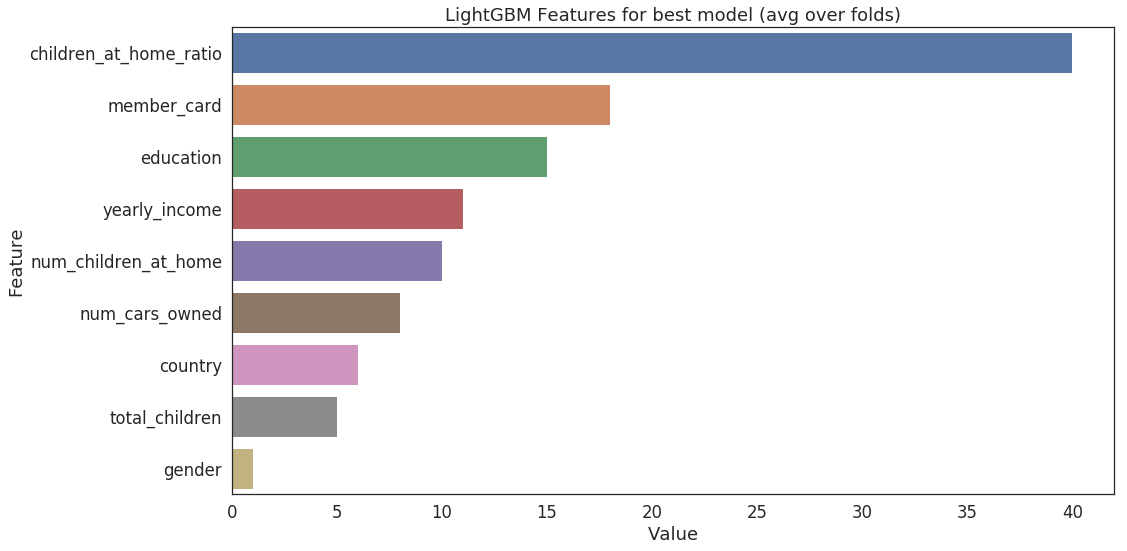

In [0]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(16, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features for best model (avg over folds)', fontsize=18)
plt.tight_layout()
plt.show()